# InternViT Classifier - threshold selection

## 0) Setup

In [33]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from epsutils.training.performance_curve_calculator import PerformanceCurveCalculator, PerformanceCurveType

ROOT_JSONL_DIR = "/home/arjun/tmp/classifier_val_data_08272025"
TARGET_PRECISION = 0.90

## 1) Read raw .jsonl data

In [34]:
# Find all jsonl files in the root directory.
jsonl_files = []
for fname in os.listdir(ROOT_JSONL_DIR):
    if fname.endswith('.jsonl'):
        jsonl_files.append(fname.split(".")[0])

print("Num labels:", len(jsonl_files))

Num labels: 360


In [35]:
output_map = {}
threshold_info = []
no_findings_stats = {}

for jsonl_file in jsonl_files:

    # Get body part and label from the jsonl file name.
    split = jsonl_file.split("release_intern_vit_classifier-training-on-")[1].split("_")
    body_part = split[0]
    label = "_".join(split[1:])

    # Create a new entry in the output map for the body part if it doesn't exist.
    if body_part not in output_map:
        output_map[body_part] = {}

    data = []
    fp = os.path.join(ROOT_JSONL_DIR, f"{jsonl_file}.jsonl")
    with open(fp, "r") as f:
        for line in f:
            data.append(json.loads(line))

    # Get predictions and labels.
    y_true = [int(d["target"][0]) for d in data]
    y_pred = [float(d["prob"]) for d in data]
    assert len(y_true) == len(y_pred)

    # Calculate the PR curve points.
    curve_calculator = PerformanceCurveCalculator()
    curve_data = curve_calculator.compute_curve(
        PerformanceCurveType.PRC, y_true, y_pred
    )
    precision = curve_data["precision"]
    recall = curve_data["recall"]
    thresholds = curve_data["thresholds"]

    # Find the threshold that gives the target precision.
    idx = np.argmax(precision >= TARGET_PRECISION)
    if idx == len(precision) - 1:
        # Find the idx where threshold is closest to 0.5
        idx = np.argmin(np.abs(thresholds - 0.5))
        print(
            f"No threshold found for {body_part} - {label} at precision={TARGET_PRECISION}. Using threshold closest to 0.5 (t={thresholds[idx]})"
        )

    # Store threshold info.
    threshold_info.append(
        {
            "body_part": body_part,
            "label": label,
            "threshold": float(thresholds[idx]),
            "precision": float(precision[idx]),
            "recall": float(recall[idx]),
            "num_samples": int(len(y_true)),
            "num_positives": int(sum(y_true)),
        }
    )
    output_map[body_part][label] = float(thresholds[idx])

    # For 'no_findings' labels, calculate recall & 90/95/99/99.9% precisions
    if label == "no_findings":
        # For each target precision, find the threshold and recall at that precision
        target_precisions = [0.90, 0.95, 0.99, 0.999]
        stats = {}
        for tp in target_precisions:
            idx_tp = np.argmax(precision >= tp)
            stats[f"precision_{int(tp*1000)/10:.1f}%"] = {
                "threshold": float(thresholds[idx_tp]),
                "precision": float(precision[idx_tp]),
                "recall": float(recall[idx_tp]),
            }
        # Also store the full recall array for this label if needed
        no_findings_stats[body_part] = {
            "label": label,
            "num_samples": int(len(y_true)),
            "num_positives": int(sum(y_true)),
            "recall_at_precisions": stats,
        }

No threshold found for l-spine - spina_bifida_occulta at precision=0.9. Using threshold closest to 0.5 (t=0.5)
No threshold found for head - hypoplastic_sinus at precision=0.9. Using threshold closest to 0.5 (t=0.5)
No threshold found for head - abnormal_calcifications at precision=0.9. Using threshold closest to 0.5 (t=0.5)
No threshold found for l-spine - lumbarization_of_s1 at precision=0.9. Using threshold closest to 0.5 (t=0.5)
No threshold found for pelvis - sacralization_of_spine at precision=0.9. Using threshold closest to 0.5 (t=0.5)
No threshold found for foot - accessory_ossicles at precision=0.9. Using threshold closest to 0.5 (t=0.5)
No threshold found for abdomen - masses at precision=0.9. Using threshold closest to 0.5 (t=0.494140625)
No threshold found for leg - patellar_tracking_abnormalities at precision=0.9. Using threshold closest to 0.5 (t=0.5)
No threshold found for c-spine - lateral_curvature at precision=0.9. Using threshold closest to 0.5 (t=0.5)
No threshold f

## 2) Compute statistics on classifier performance

### Recall @ fixed precision metrics

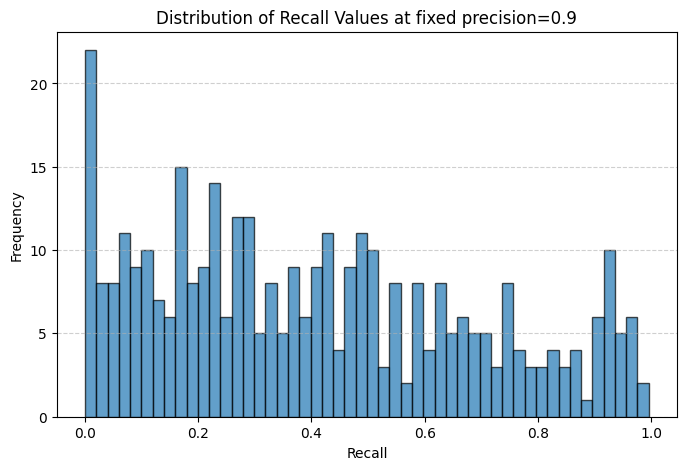

Recall Statistics at fixed precision=0.90:
  Mean recall:    0.4050
  Median recall:  0.3691
  Min recall:     0.0004
  Max recall:     0.9952
  Std deviation:  0.2803
  Percent above...
    >= 0.99:      0.3%
    >= 0.95:      2.8%
    >= 0.90:      7.2%
    >= 0.75:      15.0%
  Percent below...
    < 0.05:       9.4%
    < 0.10:       16.1%
    < 0.25:       35.8%
    < 0.50:       65.0%


In [36]:

recalls = [t["recall"] for t in threshold_info]
plt.figure(figsize=(8, 5))
plt.hist(recalls, bins=50, edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Recall Values at fixed precision={TARGET_PRECISION}')
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

import numpy as np

# Calculate useful statistics for recall values
recalls_np = np.array(recalls)
mean_recall = np.mean(recalls_np)
median_recall = np.median(recalls_np)
min_recall = np.min(recalls_np)
max_recall = np.max(recalls_np)
std_recall = np.std(recalls_np)
percent_above_99 = np.mean(recalls_np >= 0.99) * 100
percent_above_95 = np.mean(recalls_np >= 0.95) * 100
percent_above_90 = np.mean(recalls_np >= 0.90) * 100
percent_above_75 = np.mean(recalls_np >= 0.75) * 100
percent_below_5 = np.mean(recalls_np < 0.05) * 100
percent_below_10 = np.mean(recalls_np < 0.10) * 100
percent_below_25 = np.mean(recalls_np < 0.25) * 100
percent_below_50 = np.mean(recalls_np < 0.50) * 100

print("Recall Statistics at fixed precision={:.2f}:".format(TARGET_PRECISION))
print(f"  Mean recall:    {mean_recall:.4f}")
print(f"  Median recall:  {median_recall:.4f}")
print(f"  Min recall:     {min_recall:.4f}")
print(f"  Max recall:     {max_recall:.4f}")
print(f"  Std deviation:  {std_recall:.4f}")
print(f"  Percent above...")
print(f"    >= 0.99:      {percent_above_99:.1f}%")
print(f"    >= 0.95:      {percent_above_95:.1f}%")
print(f"    >= 0.90:      {percent_above_90:.1f}%")
print(f"    >= 0.75:      {percent_above_75:.1f}%")
print(f"  Percent below...")
print(f"    < 0.05:       {percent_below_5:.1f}%")
print(f"    < 0.10:       {percent_below_10:.1f}%")
print(f"    < 0.25:       {percent_below_25:.1f}%")
print(f"    < 0.50:       {percent_below_50:.1f}%")

### 'No findings' high-precision stats.

In [37]:
# For each body part, output recall at 90/95/99/99.9% precision for the 'no_findings' label using the new no_findings_stats structure

# Define the precision keys and their display names
precision_keys = [
    "precision_90.0%",
    "precision_95.0%",
    "precision_99.0%",
    "precision_99.9%",
]
precision_display = [
    "Recall@P>=90.0%",
    "Recall@P>=95.0%",
    "Recall@P>=99.0%",
    "Recall@P>=99.9%",
]

print("Recall for 'no_findings' at various precision levels by body part:")
header = ["Body Part"] + precision_display
row_format = "{:<20}" + "{:>18}" * len(precision_keys)
print(row_format.format(*header))

for body_part in sorted(no_findings_stats.keys()):
    stats = no_findings_stats[body_part]
    recall_at_precisions = stats.get("recall_at_precisions", {})
    row = [body_part]
    for key in precision_keys:
        recall_info = recall_at_precisions.get(key, None)
        if recall_info is not None and "recall" in recall_info and recall_info["recall"] is not None:
            row.append(f"{recall_info['recall']:.4f}")
        else:
            row.append("N/A")
    print(row_format.format(*row))

Recall for 'no_findings' at various precision levels by body part:
Body Part              Recall@P>=90.0%   Recall@P>=95.0%   Recall@P>=99.0%   Recall@P>=99.9%
abdomen                         0.0938            0.0044            0.0010            0.0010
arm                             0.2287            0.0454            0.0005            0.0005
c-spine                         0.4052            0.1810            0.0001            0.0001
chest                           0.5381            0.2320            0.0014            0.0014
foot                            0.2155            0.0055            0.0003            0.0003
hand                            0.2841            0.0727            0.0000            0.0000
head                            0.0356            0.0143            0.0132            0.0132
l-spine                         0.1784            0.0201            0.0002            0.0002
leg                             0.3218            0.0452            0.0007            0.0007
pel

## 3) Write chosen thresholds to file (and dump raw data to notebook).

In [38]:
# Write the thresholds to a json file for ingestion by production inference code.
output_fp = "/home/arjun/tmp/classifier_thresholds_by_label.json"
with open(output_fp, "w") as f:
    json.dump(output_map, f, indent=2)
print(f"Thresholds written to {output_fp}")

Thresholds written to /home/arjun/tmp/classifier_thresholds_by_label.json


In [39]:
for t in threshold_info:
    body_part = t.get("body_part", "N/A")
    label = t.get("label", "N/A")
    threshold = t.get("threshold", "N/A")
    precision = t.get("precision", "N/A")
    recall = t.get("recall", "N/A")
    print(f"Body part: {body_part}, Label: {label} (num_samples={t.get('num_samples', 'N/A')}, num_positives={t.get('num_positives', 'N/A')})")
    print(f"  Threshold: {threshold}")
    print(f"  Precision: {precision}")
    print(f"  Recall:    {recall}")
    print("")


Body part: arm, Label: fracture (num_samples=34176, num_positives=17086)
  Threshold: 0.4609375
  Precision: 0.9001213101496158
  Recall:    0.6514105115299075

Body part: hand, Label: tendon_avulsion_fractures (num_samples=2912, num_positives=1458)
  Threshold: 0.71875
  Precision: 0.9064748201438849
  Recall:    0.1728395061728395

Body part: c-spine, Label: fracture (num_samples=1632, num_positives=815)
  Threshold: 0.75390625
  Precision: 0.9019607843137255
  Recall:    0.11288343558282209

Body part: l-spine, Label: support_devices (num_samples=55424, num_positives=27712)
  Threshold: 0.388671875
  Precision: 0.9004642936104356
  Recall:    0.7348441108545035

Body part: abdomen, Label: diaphragmatic_hernia (num_samples=640, num_positives=320)
  Threshold: 0.515625
  Precision: 0.9111111111111111
  Recall:    0.25625

Body part: abdomen, Label: no_findings (num_samples=26336, num_positives=13170)
  Threshold: 0.75
  Precision: 0.9015317286652079
  Recall:    0.0938496583143508

Bo